# Malware DNS detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of DNS malware

Raw data from: CIC-Bell-DNS [1]

-----------------------------------------------------------------------
[1] Samaneh Mahdavifar et al. Classifying Malicious Domains using DNS Traffic Analysis. In DASC/PiCom/CBDCom/CyberSciTech 2021, pages 60–67. IEEE, 2021

In [2]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split



In [4]:
df = pd.read_csv("../cnsm_final_datasets/dns_malware.csv")

In [5]:
df

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,8.8.8.8,150.150.150.10,397,396,13891,32844,1.571319e+09,1.571320e+09,...,6549.301954,0.145137,0.457453,0.283622,-0.175921,5.479869,2.770816,-0.559445,0.762729,True
1,1,1,8.8.8.8,150.150.150.10,633,634,21194,54658,1.571320e+09,1.571320e+09,...,11184.093823,0.079577,0.483522,0.302905,-0.116849,7.701636,0.524329,-0.617655,0.998333,True
2,2,2,8.8.8.8,150.150.150.10,552,551,18276,47900,1.571320e+09,1.571320e+09,...,7868.089367,0.037063,0.469737,0.282013,-0.130984,6.103569,0.755797,-0.154165,0.994406,True
3,3,3,8.8.8.8,150.150.150.10,453,454,14459,38276,1.571320e+09,1.571321e+09,...,8180.896777,0.031301,0.461049,0.276115,-0.177526,5.548300,0.888593,-0.307735,0.970823,True
4,4,4,8.8.8.8,150.150.150.10,543,542,17855,45360,1.571321e+09,1.571321e+09,...,11846.111252,0.224405,0.481590,0.289643,-0.081200,9.947926,0.568424,-0.113041,0.999875,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,6128,6128,8.8.8.8,150.150.150.10,320,320,11040,25577,1.568126e+09,1.568126e+09,...,8380.201086,0.118317,0.516863,0.297870,0.064206,6.029364,0.344584,-0.098936,0.995989,False
6386,6129,6129,8.8.8.8.,150.150.150.10,7,0,66,0,1.566519e+09,1.566519e+09,...,338487.267143,0.031699,0.180633,0.206478,NaN,2769.505348,375.425426,-0.000199,0.028161,False
6387,6130,6130,8.8.8.8.,150.150.150.10,7,0,66,0,1.566519e+09,1.566519e+09,...,16363.165957,0.006667,0.503960,0.290931,-0.016445,1.289827,0.076152,-0.309324,0.969318,False
6388,6131,6131,150.150.150.10.,8.8.8.8,6,0,868,0,1.566519e+09,1.566519e+09,...,-350503.519625,0.846232,0.788379,0.155292,NaN,-155.858141,28987.449578,0.000199,0.000373,False


In [6]:
print(f"malware: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

malware: 257	clear: 6133


In [7]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [8]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in frequency_features: 
        df.replace([np.inf], -1, inplace=True)
        df.replace([-np.inf], -1, inplace=True)
        df.loc[df[F].isnull(), F] = -1
    else:
        df.replace([np.inf], 0, inplace=True)
        df.replace([-np.inf], 0, inplace=True)
        df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [9]:
df

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,0,8.8.8.8,150.150.150.10,397,396,13891,32844,1.571319e+09,1.571320e+09,53,46177,118,103.0,32.480764,1056,-0.568307,92.0,150.0,85,243,158,92,27.526071,28,23.728814,123.285176,0.634300,0.359395,0.800474,7.727651,2.085956,2.726882e-05,2.732052e-05,0.103448,2.699452,5.743945,0.596391,0.622384,False,0.698613,0.515014,0.494923,0.543803,0.758422,163.085761,176.349766,90.306549,245.439405,299.898332,0.378660,0.036665,0.000025,5.005048,0.075656,False,1.795455,False,0.0,0.494923,28487,0.500631,False,0,0,4.568211e-06,0.026409,0.705179,0.145733,0.004819,0.004285,0.00117,24.095953,172.716474,2.250293e+04,6549.301954,0.145137,0.457453,0.283622,-0.175921,5.479869,2.770816,-0.559445,True,True,1
1,1,1,8.8.8.8,150.150.150.10,633,634,21194,54658,1.571320e+09,1.571320e+09,53,46177,119,103.0,33.689761,1136,-0.558716,92.0,152.0,85,254,169,91,28.310724,29,24.369748,124.510483,0.624309,0.374901,0.831113,7.539383,1.969270,2.268440e-05,2.271130e-05,0.100000,3.213281,5.936724,0.575978,0.630386,False,0.687056,0.175325,0.657049,0.562057,0.681110,168.496946,175.223572,110.381471,218.344563,299.786230,0.236798,0.037516,0.000141,5.005074,0.047312,False,1.935229,False,0.0,0.657049,39553,0.499605,False,0,0,1.757381e-08,0.008490,0.972783,0.355128,0.001102,0.001152,0.00000,5.511692,50.588937,5.137935e+04,11184.093823,0.079577,0.483522,0.302905,-0.116849,7.701636,0.524329,-0.617655,True,True,1
2,2,2,8.8.8.8,150.150.150.10,552,551,18276,47900,1.571320e+09,1.571320e+09,53,46177,119,101.0,33.241540,1106,-0.563305,92.0,153.0,85,248,163,91,27.934067,30,25.210084,124.511936,0.611967,0.387126,0.842320,7.701208,1.920872,2.712556e-05,2.716252e-05,0.114754,2.246711,5.758462,0.569738,0.609222,False,0.689937,0.644237,0.717148,0.386026,0.785041,115.716338,87.535478,28.168263,194.447774,299.763384,0.272018,0.035593,0.000135,5.005108,0.054348,False,1.898367,False,0.0,0.717148,29873,0.500453,False,0,0,8.624250e-08,0.008028,0.590151,0.435985,0.001315,0.001244,0.00003,6.576570,59.115688,2.997055e+04,7868.089367,0.037063,0.469737,0.282013,-0.130984,6.103569,0.755797,-0.154165,True,True,1
3,3,3,8.8.8.8,150.150.150.10,453,454,14459,38276,1.571320e+09,1.571321e+09,53,46177,118,97.0,33.196385,1102,-0.560884,91.0,153.0,84,248,164,88,28.132530,30,25.423729,122.715279,0.619625,0.380375,0.903713,7.741807,0.947421,3.887855e-06,3.894298e-06,0.129032,2.561905,5.583488,0.568296,0.668806,False,0.717200,0.243337,0.419881,0.503319,0.762210,150.313386,139.681527,78.638416,244.186947,298.644213,0.329629,0.035728,0.000057,5.005081,0.065859,False,1.843267,False,0.0,0.419881,27209,0.499449,False,0,0,2.178698e-07,0.009245,0.908613,0.600879,0.001666,0.001617,0.00043,8.331683,71.947076,2.907222e+04,8180.896777,0.031301,0.461049,0.276115,-0.177526,5.548300,0.888593,-0.307735,True,True,1
4,4,4,8.8.8.8,150.150.150.10,543,542,17855,45360,1.571321e+09,1.571321e+09

In [10]:
print(f"ddos: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

ddos: 257	clear: 6133


In [11]:
df = df[["LABEL_code"] + features].copy()

In [12]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [13]:
df.shape

(6390, 77)

In [14]:
print(f"malware dns: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

malware dns: 257	clear: 6133


In [15]:
df_validation = df.sample(n = 1000)
df_features =  df[~df.isin(df_validation)].dropna()

In [16]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [20]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 50, 2),
        'gamma': hp.uniform ('gamma', 1,18),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [21]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [00:06<00:00, 15.50trial/s, best loss: -0.85]             
The best hyperparameters are :  

{'colsample_bytree': 0.2763155040569786, 'gamma': 15.173543986313838, 'max_depth': 20.0, 'min_child_weight': 19.0, 'n_estimators': 60.0, 'reg_alpha': 0.0, 'reg_lambda': 0.21648888829488008}


In [22]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

99.13 & 96.49 & 82.09 & 88.71 \\


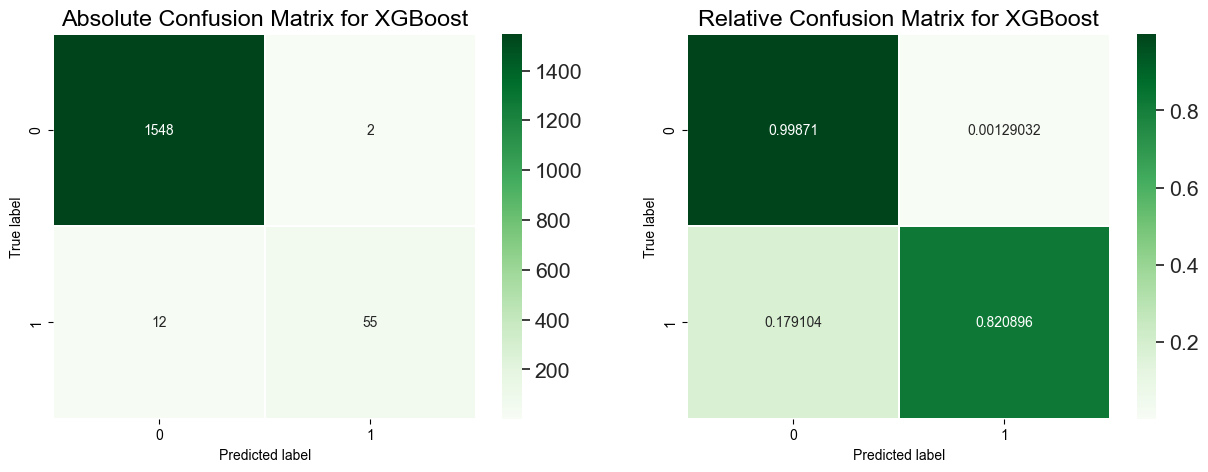

In [23]:
model = XGBoost_classification_tunned(best_hyperparams)

In [24]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

99


92.06349206349206
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}99.38 & 98.31 & 86.57 & 92.06 \\
\hline



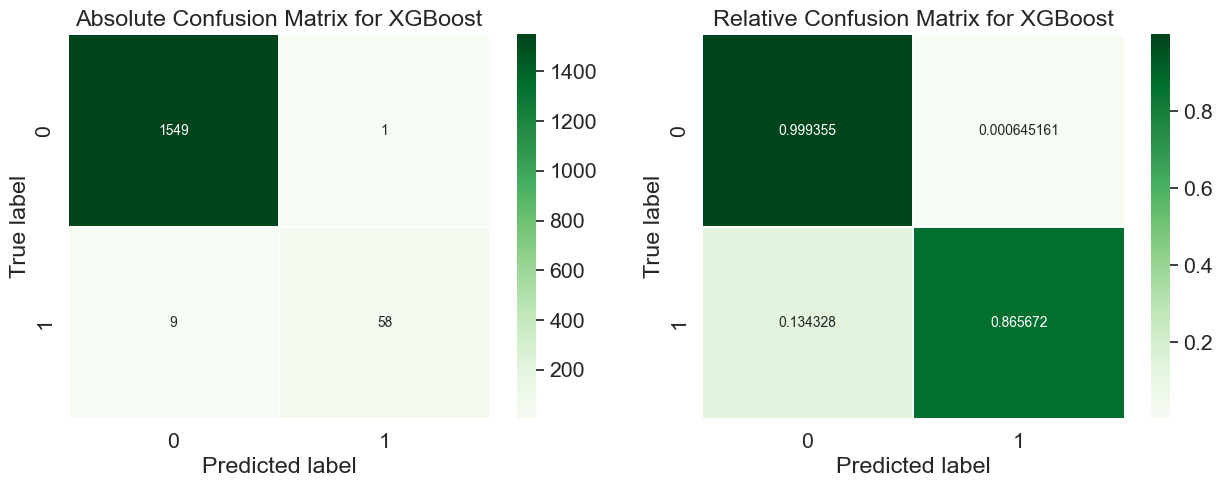

In [25]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=100)

99.50 & 91.67 & 94.29 & 92.96 \\


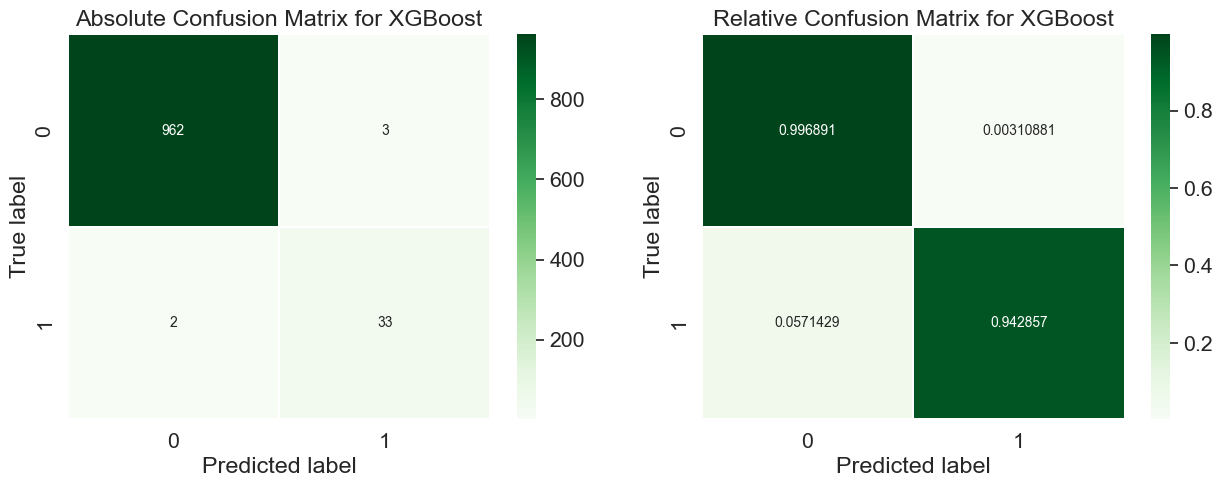

In [26]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [35]:
import csv

problem = "DNS_Malware"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

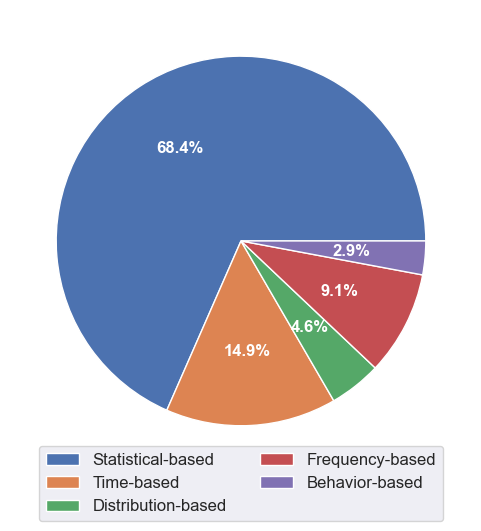

In [27]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [28]:
data

[0.6842659, 0.14947642, 0.045675788, 0.091134205, 0.029447665]

In [29]:
feat_importances

PACKETS                     0.000000
TIME_DISTRIBUTION           0.000000
AREA_VALUES_DISTRIBUTION    0.000000
SPECTRAL_BANDWIDTH          0.000000
MEDIAN_SCALED_TIME          0.000000
                              ...   
VAR                         0.041994
HURST_EXPONENT              0.045676
MEDIAN_DIFFTIMES            0.089885
MEDIAN                      0.220154
Q3                          0.315380
Length: 76, dtype: float32

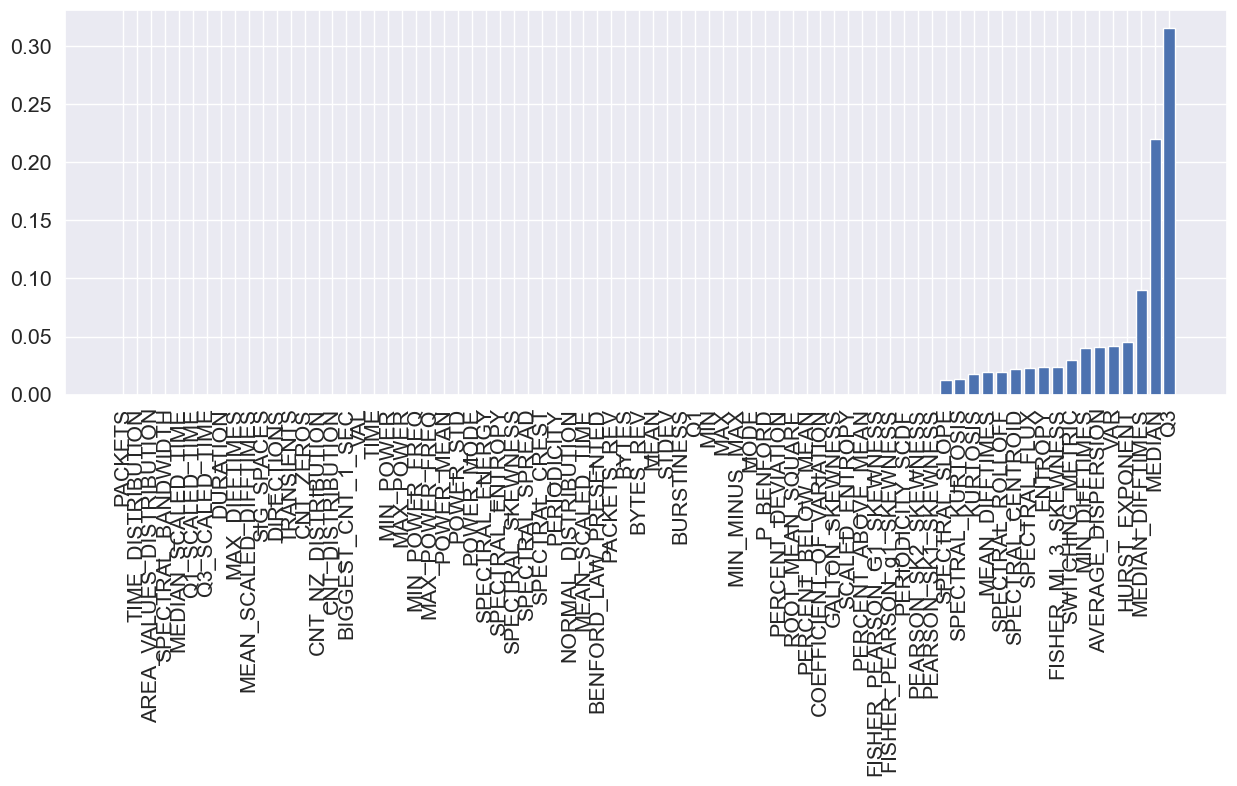

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [31]:
feat_importances.to_dict()

{'PACKETS': 0.0,
 'TIME_DISTRIBUTION': 0.0,
 'AREA_VALUES_DISTRIBUTION': 0.0,
 'SPECTRAL_BANDWIDTH': 0.0,
 'MEDIAN_SCALED_TIME': 0.0,
 'Q1_SCALED_TIME': 0.0,
 'Q3_SCALED_TIME': 0.0,
 'DURATION': 0.0,
 'MAX_DIFFTIMES': 0.0,
 'MEAN_SCALED_DIFFTIMES': 0.0,
 'SIG_SPACES': 0.0,
 'DIRECTIONS': 0.0,
 'TRANSIENTS': 0.0,
 'CNT_ZEROS': 0.0,
 'CNT_NZ_DISTRIBUTION': 0.0,
 'CNT_DISTRIBUTION': 0.0,
 'BIGGEST_CNT_1_SEC': 0.0,
 'VAL': 0.0,
 'TIME': 0.0,
 'MIN_POWER': 0.0,
 'MAX_POWER': 0.0,
 'MIN_POWER_FREQ': 0.0,
 'MAX_POWER_FREQ': 0.0,
 'POWER_MEAN': 0.0,
 'POWER_STD': 0.0,
 'POWER_MODE': 0.0,
 'SPECTRAL_ENERGY': 0.0,
 'SPECTRAL_ENTROPY': 0.0,
 'SPECTRAL_SKEWNESS': 0.0,
 'SPECTRAL_SPREAD': 0.0,
 'SPECTRAL_CREST': 0.0,
 'PERIODICITY': 0.0,
 'NORMAL_DISTRIBUTION': 0.0,
 'MEAN_SCALED_TIME': 0.0,
 'BENFORD_LAW_PRESENTED': 0.0,
 'PACKETS_REV': 0.0,
 'BYTES': 0.0,
 'BYTES_REV': 0.0,
 'MEAN': 0.0,
 'STDEV': 0.0,
 'BURSTINESS': 0.0,
 'Q1': 0.0,
 'MIN': 0.0,
 'MAX': 0.0,
 'MIN_MINUS_MAX': 0.0,
 'MODE': 0.0,


# Featuer selection

In [33]:
def perform_val(selected_features, best_hyperparams=None, cycles=100):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features, selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [34]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [00:06<00:00, 16.07trial/s, best loss: -0.7476635514018691]
The best hyperparameters are :  

{'colsample_bytree': 0.2681571389548412, 'gamma': 6.394774624023922, 'max_depth': 16.0, 'min_child_weight': 9.0, 'n_estimators': 280.0, 'reg_alpha': 0.0, 'reg_lambda': 0.8540477162454725}
100%|██████████| 100/100 [00:04<00:00, 20.06trial/s, best loss: -0.6262626262626263]
The best hyperparameters are :  

{'colsample_bytree': 0.7840237952193174, 'gamma': 10.002262384413083, 'max_depth': 26.0, 'min_child_weight': 18.0, 'n_estimators': 200.0, 'reg_alpha': 0.0, 'reg_lambda': 0.7656106517903365}
100%|██████████| 100/100 [00:03<00:00, 26.01trial/s, best loss: -0.7238095238095238]
The best hyperparameters are :  

{'colsample_bytree': 0.3327808805023442, 'gamma': 10.049048449535317, 'max_depth': 42.0, 'min_child_weight': 7.0, 'n_estimators': 200.0, 'reg_alpha': 11.0, 'reg_lambda': 0.7962365490576858}
100%|██████████| 100/100 [00:03<00:00, 28.86trial/s, best loss: -0.78181818

In [36]:
import csv

problem = "DNS_Malware"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])